## Declarations

### Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import random
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow_hub as hub
import tensorflow_text as text

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.13.0
Num GPUs Available:  1


In [2]:
def split(x1, x2, test_size=0.2, val_size=0.0, seed=0):
    if val_size + test_size >= 1:
        return None
    x1_train, x1_test, x2_train, x2_test = train_test_split(
        x1, x2, test_size=test_size + val_size, random_state=seed
    )
    x1_val = None
    x2_val = None
    if val_size > 0:
        x1_test, x1_val, x2_test, x2_val = train_test_split(
            x1,
            x2,
            test_size=val_size / (test_size + val_size),
            random_state=seed,
        )
    return x1_train, x1_val, x1_test, x2_train, x2_val, x2_test


def create_dataset(x1, x2, vectorization=None):

    if x1 is None or x2 is None:
        return None 

    dataset = tf.data.Dataset.from_tensor_slices((x1, x2))

    if vectorization is None:
        return dataset.map(lambda i, c: {'image': i, 'caption': c})
    
    else:
        return dataset.map(lambda i, c: {'image': i, 'caption': vectorization(c)})
    

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    # TODO
    #return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")
    return lowercase
    

### Constants

In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_det_file = "concept_detection_train.csv"
concept_file = "concepts.csv"

image_size = (128, 128, 3)

batch_size = 10
epochs = 100
learning_rate = 2e-5

## Preprocessing

### File Reading and Pre-processing

In [4]:
captions_df = pd.read_csv(caption_pred_file, sep='\t')

In [5]:
# Usually if we extract a string from the dataframe it will get truncated to 
# 50 characters. This way instead we select the longest string in the dataframe and
# use that as max truncation. This means that no string will be truncated
max_len = captions_df.caption.str.len().max()
pd.set_option('display.max_colwidth', int(max_len))

In [6]:
# Ad [SOS] and [EOS] tokens at the beginning and end of every caption.
captions_df['caption'] = captions_df['caption'].map('[SOS] {} [EOS]'.format)

In [7]:
# Compute size of vocabulary
result = ""
for i in captions_df['caption'].to_numpy():
    result += " " + i

In [8]:
captions_df = pd.read_csv(caption_pred_file, sep='\t')

# Usually if we extract a string from the dataframe it will get truncated to 
# 50 characters. This way instead we select the longest string in the dataframe and
# use that as max truncation. This means that no string will be truncated
max_len = captions_df.caption.str.len().max()
pd.set_option('display.max_colwidth', int(max_len))

# Ad [SOS] and [EOS] tokens at the beginning and end of every caption.
captions_df['caption'] = captions_df['caption'].map('[SOS] {} [EOS]'.format)

# Compute size of vocabulary
result = ""
for i in captions_df['caption'].to_numpy():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
vocab_size = len(set(result.split()))
print(f"Vocab size: {vocab_size}")

# Compute longest sequence
idx = captions_df.caption.str.len().idxmax()
longest = captions_df['caption'][idx]
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
sequence_length = len(longest)
print(f"Longest sequence: {sequence_length}")

Vocab size: 35491
Longest sequence: 393


In [9]:
# Get the filenames of the images
image_filenames = sorted(os.listdir(image_dir))
num_images = len(image_filenames)

# Pre-allocate the whole numpy array to store images
images = np.zeros((num_images, image_size[0], image_size[1], image_size[2]), dtype=np.float16)

captions = []

# Iterate over the dataframe and match the images with captions
for i, image_filename in enumerate(tqdm(image_filenames)):
    
    # Extract the image ID from the filename
    image_id = image_filename.split('.')[0]

    # Load image
    image_path = image_dir + '/' + image_filename
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_size[0], image_size[1]))
    image = tf.keras.preprocessing.image.img_to_array(image, dtype='float16')
    image /= 255.0

    # Insert image in array
    images[i] = image

    # Find corresponding caption
    caption = captions_df[captions_df['ID'] == image_id]['caption'].to_string(index=False)
    captions.append(caption)

100%|██████████| 83275/83275 [06:13<00:00, 222.79it/s]


In [10]:
train_images, val_images, test_images, train_captions, val_captions, test_captions = split(
        images, captions, test_size=0.2, seed=seed
    )

# Free unused memory
del captions, images

### Download Models

In [11]:
text_preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )

text_transformer = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        trainable=True,
        name="bert",
    )

img_preprocess = tfk.applications.convnext.preprocess_input

img_supernet = tfk.applications.ConvNeXtTiny(weights='imagenet', include_top=False)

In [12]:
train_ds = create_dataset(train_images, train_captions)
val_ds = create_dataset(val_images, val_captions)
test_ds = create_dataset(test_images, test_captions)

In [13]:
del train_images, val_images, test_images, train_captions, val_captions, test_captions

## Network

### Network blocks

In [14]:
def image_encoder(input_shape, latent_dim, embed_dim, seed=42, supernet=None, preprocessing=None):
    
    tf.random.set_seed(seed)

    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')

    x = preprocessing(input_layer)
    x = supernet(x)

    x = tfkl.GlobalAveragePooling2D(name='GAP')(x)

    # Projection
    embeddings = tfkl.Dense(embed_dim)(x)
    x = tf.nn.selu(embeddings)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)
    x = tfkl.Dropout(0.1)(x)
    x = tfkl.Add()([x, embeddings])
    x = tfkl.LayerNormalization()(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the encoder
    return cnn_encoder

In [15]:
def text_encoder(latent_dim, embed_dim, preprocess, transformer, trainable=True):

    transformer.trainable = trainable
    
    input_layer = tfkl.Input(shape=(), dtype=tf.string, name="text_input")
    x = preprocess(input_layer)
    x = transformer(x)["pooled_output"]
    

    # Projection
    embeddings = tfkl.Dense(embed_dim)(x)
    x = tf.nn.selu(embeddings)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)
    x = tfkl.Dropout(0.1)(x)
    x = tfkl.Add()([x, embeddings])
    x = tfkl.LayerNormalization()(x)

    text_encoder = tfk.Model(inputs=input_layer, outputs=x, name="text_encoder")
    
    return text_encoder

In [16]:
class CLIP(tfk.Model):
    def __init__(self, image_encoder, text_encoder, temp=0.07, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.temp = temp
        self.loss_tracker = tfk.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        image_emb = self.image_encoder(features["image"], training=training)
        text_emb = self.text_encoder(features["caption"], training=training)
        return image_emb, text_emb

    def CLIP_loss(self, image_emb, text_emb):
        norm_image_emb = tf.math.l2_normalize(image_emb, axis=1)
        norm_text_emb = tf.math.l2_normalize(text_emb, axis=1)

        logits = tf.linalg.matmul(norm_image_emb, norm_text_emb, transpose_b=True) * tf.math.exp(self.temp)

        n = tf.shape(logits)[0]
        labels = tf.range(n)

        loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits), from_logits=True)

        return (loss_img + loss_txt) / tf.constant(2.0)

    def train_step(self, features):
        with tf.GradientTape() as tape:
            image_embeddings, caption_embeddings = self(features, training=True)
            loss = self.CLIP_loss(caption_embeddings, image_embeddings)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        image_embeddings, caption_embeddings = self(features, training=False)
        loss = self.CLIP_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Building network

In [17]:
def build_clip(img_input_shape=(128,128,3),
               txt_input_shape=(393, ), 
               latent_dim=1024, 
               embed_dim=64, 
               temp=0.07,
               learning_rate=2e-5,
               img_supernet=None,
               img_preprocess=None,
               text_transformer=None,
               text_preprocess=None):

    
    text_encoder_model = text_encoder(latent_dim, embed_dim, text_preprocess, text_transformer)
    image_encoder_model = image_encoder(img_input_shape, latent_dim, embed_dim, supernet=img_supernet, preprocessing=img_preprocess)

    clip = CLIP(image_encoder_model, text_encoder_model, temp)
    clip.compile(optimizer = tf.optimizers.Adam(learning_rate=learning_rate))

    return image_encoder_model, text_encoder_model, clip

In [18]:
image_encoder, text_encoder, clip = build_clip(
    img_supernet=img_supernet,
    img_preprocess=img_preprocess,
    text_transformer=text_transformer,
    text_preprocess=text_preprocess,
    learning_rate=learning_rate
    )

## Training

### Phase 1
Traning all the parameters

In [19]:
# Create a learning rate scheduler callback.
reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor = "val_loss", factor = 0.2, patience = 3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = 5, restore_best_weights = True
)


history_phase1 = clip.fit(
    train_ds.batch(batch_size),
    epochs = epochs,
    validation_data = test_ds.batch(batch_size),
    callbacks = [reduce_lr, early_stopping],
)

Epoch 1/100
6662/6662 [==============================] - 493s 70ms/step - loss: 1.8453 - val_loss: 1.7071 - lr: 2.0000e-05
Epoch 2/100
6662/6662 [==============================] - 435s 65ms/step - loss: 1.6834 - val_loss: 1.6727 - lr: 2.0000e-05
Epoch 3/100
6662/6662 [==============================] - 437s 66ms/step - loss: 1.6334 - val_loss: 1.6424 - lr: 2.0000e-05
Epoch 4/100
6662/6662 [==============================] - 434s 65ms/step - loss: 1.6019 - val_loss: 1.6305 - lr: 2.0000e-05
Epoch 5/100
6662/6662 [==============================] - 446s 67ms/step - loss: 1.5800 - val_loss: 1.6280 - lr: 2.0000e-05
Epoch 6/100
6662/6662 [==============================] - 445s 67ms/step - loss: 1.5639 - val_loss: 1.6235 - lr: 2.0000e-05
Epoch 7/100
6662/6662 [==============================] - 444s 67ms/step - loss: 1.5505 - val_loss: 1.6185 - lr: 2.0000e-05
Epoch 8/100
6662/6662 [==============================] - 442s 66ms/step - loss: 1.5391 - val_loss: 1.6290 - lr: 2.0000e-05
Epoch 9/100
6662

In [20]:
clip.save("selu.keras")

### Phase 2
Training the projection only

In [21]:
img_supernet.trainable = False
text_transformer.trainable = False

In [23]:
clip.compile(optimizer = tf.optimizers.Adam(learning_rate=learning_rate))

In [24]:
history_phase2 = clip.fit(
    train_ds.batch(batch_size),
    epochs = epochs,
    validation_data = test_ds.batch(batch_size),
    callbacks = [early_stopping],
)

Epoch 1/100
6662/6662 [==============================] - 200s 29ms/step - loss: 1.5165 - val_loss: 1.6133
Epoch 2/100
6662/6662 [==============================] - 192s 29ms/step - loss: 1.5158 - val_loss: 1.6132
Epoch 3/100
6662/6662 [==============================] - 191s 29ms/step - loss: 1.5154 - val_loss: 1.6131
Epoch 4/100
6662/6662 [==============================] - 190s 28ms/step - loss: 1.5150 - val_loss: 1.6130
Epoch 5/100
6662/6662 [==============================] - 190s 29ms/step - loss: 1.5148 - val_loss: 1.6129
Epoch 6/100
6662/6662 [==============================] - 191s 29ms/step - loss: 1.5146 - val_loss: 1.6128
Epoch 7/100
6662/6662 [==============================] - 191s 29ms/step - loss: 1.5144 - val_loss: 1.6127
Epoch 8/100
6662/6662 [==============================] - 191s 29ms/step - loss: 1.5142 - val_loss: 1.6127
Epoch 9/100
6662/6662 [==============================] - 191s 29ms/step - loss: 1.5140 - val_loss: 1.6127
Epoch 10/100
6662/6662 [======================

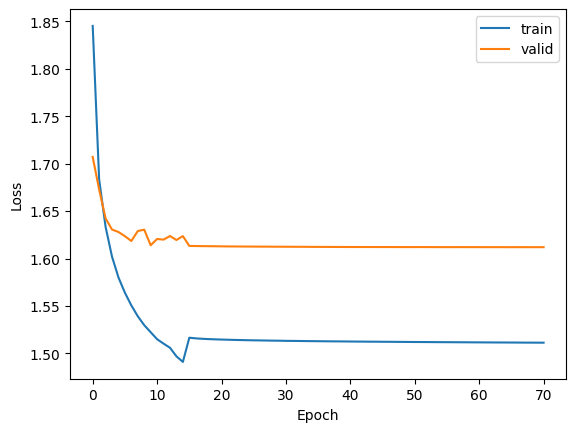

In [25]:
plt.plot(history_phase1.history["loss"]+history_phase2.history["loss"])
plt.plot(history_phase1.history["val_loss"]+history_phase2.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [26]:
clip.save("models/2phase_selu.keras")

### Encoder/Decoder training

In [ ]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return image_array

In [ ]:
def find_matches(image_embeddings, queries, k=5, normalize=True):
    queries_vec = [text_vectorization(query) for query in queries]
    queries_vec = tf.data.Dataset.from_tensor_slices(queries_vec).batch(batch_size)
    # Get the embedding for the query.
    query_embedding = text_encoder.predict(queries_vec)
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[train_image_paths[idx] for idx in indices] for indices in results]

In [ ]:
train_data = [p for p in ds_train]
val_data = [p for p in ds_val]
test_data = [p for p in ds_test]

train_image_paths = [e["image path"] for e in train_data]
test_image_paths = [e["image path"] for e in test_data]

# TODO: this part only generates embeddings on the training dataset for now
# TODO: this code re-reads the images
image_embeddings = image_encoder.predict(
    tf.data.Dataset.from_tensor_slices(train_image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")


In [ ]:
query = "active pheochromocytoma"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

print("Top matches for query: \"" + query + "\"")

plt.figure(figsize=(18, 18))
for i in range(9):
    path = matches[i].numpy().decode('UTF-8')
    caption = next(x["raw caption"] for x in train_data if x["image path"].numpy().decode('UTF-8') == path)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(path))
    plt.axis("off")
    print(caption)


## Evaluation

In [ ]:
# TODO: might not work, needs revising

def compute_top_k_accuracy(image_paths, k=5):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in range(num_batches):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [ captions[os.path.splitext(image_path.numpy().decode('UTF-8').split(os.sep)[-1])[0]] for image_path in current_image_paths ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)

n = 1920

print(test_image_paths)

print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(random.sample(train_image_paths, n))
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(random.sample(test_image_paths, n))
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")
